In [59]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import models.helpers as mh

import data.breathe_data as bd
import data.helpers as dh
from scipy.stats import norm
from scipy.stats import laplace
import pandas as pd

from scipy import stats

import itertools

In [2]:
df = bd.load_meas_from_excel("BR_O2_FEV1_FEF2575_conservative_smoothing_with_idx")

## Impact of the max number of days with missing data allowed to constitute a sequence on the distribution of day-to-day change in FEV1

In [ ]:
# Also quantify distribution's asymmetry

In [12]:
df.columns
cols_keep = ["ID", "Date Recorded", "ecFEV1"]
df = df[cols_keep]


In [58]:
# For a given amount days with missing data allowed, what is the distribution of day-to-day change in FEV1?
# Interested in the distribution as a whole, rather than the data per sequence

def get_df_d2d(df, n_missing_days_allowed):
    def get_subdf(df_for_ID, n_missing_days_allowed):
        subdf, _, _ = dh.find_longest_conseq_sequence(df_for_ID, n_missing_days_allowed)
        return subdf

    # print(len(df), "initial size")
    df_seq = df.groupby("ID").apply(get_subdf, n_missing_days_allowed).reset_index(drop=True)
    # print(len(df_seq), "after removing sequences with missing data")
    df_seq.head(2)

    def get_day_to_day_change_in_ecFEV1(df_for_ID):
        df_for_ID = df_for_ID.sort_values(by="Date Recorded", ascending=True)
        # Computes diff with previous row
        df_for_ID["day_to_day_ecFEV1"] = df_for_ID["ecFEV1"].diff(periods=1)
        return df_for_ID

    df_d2d = df_seq.groupby("ID").apply(get_day_to_day_change_in_ecFEV1).reset_index(drop=True)
    df_d2d.dropna(inplace=True)
    # print(len(df_d2d), "after making diff")

    return df_d2d

In [94]:
fev1_col = 'ecFEV1'
ecFEV1_change_0 = get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"]

# Perform Anderson-Darling test to compare distributions
for n_missing_days_allowed in [1, 2, 3]:
    print(n_missing_days_allowed)
    ecFEV1_change_1 = get_df_d2d(df, n_missing_days_allowed)[f"day_to_day_{fev1_col}"]
    statistic, critical_values, pvalue = stats.anderson_ksamp([ecFEV1_change_0, ecFEV1_change_1])
    print(f"Anderson-Darling statistic {statistic:.4f}")
    print(f"Critial values {critical_values}")
    print(f"p-value {pvalue}")
    # print(f"Distributions are {'different' if {pvalue} < 0.05 else 'not different'} (p < 0.05)")


# When allowing 2 days with missing data, the distribution are the same a signficance level of 0.5% but not at 0.1%
# When allowing 3 days with missing data, the distribution are different a signficance level of 0.1%

1
Anderson-Darling statistic 1.7393
Critial values [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
p-value 0.06226422506168248
2
Anderson-Darling statistic 4.8938
Critial values [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
p-value 0.003787769710916561
3
Anderson-Darling statistic 7.3691
Critial values [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
p-value 0.001


/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_3348/1692137431.py:8: UserWarning:

p-value floored: true value smaller than 0.001



In [53]:
fev1_col = 'ecFEV1'
fig = make_subplots(rows=1, cols=1)
xbins = dict(start=-0.605, end=0.605, size=0.01)
fig.add_trace(
    go.Histogram(x=get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"], xbins=xbins, histnorm="probability")
)
fig.update_layout(
    barmode='overlay'
)

fig.update_xaxes(title_text=f"Day-to-day change in {fev1_col}", row=1, col=1, nticks=10)
title= f"Change in {fev1_col} with longest sequence of consecutive days<br>({n_missing_days_allowed} days with missing data allowed)"
fig.update_layout(
    title=title,
    width=800,
    height=450,
    font_size=10,
    showlegend=False
)
fig.show()

41260 initial size
4568 after removing sequences with missing data
4216 after making diff


# Does the data fits a laplace?

ecFEV1 dist is only indicative of the change. The real change is learning the factor shape using the bayesian setting. no goodness of fit, but a higher P(D|S) 

In [101]:
from scipy.stats import laplace, kstest
import numpy as np

data = get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"]

# Fit Laplace distribution (returns location and scale)
loc, scale = laplace.fit(data)
print(f"Fitted Laplace: loc = {loc:.3f}, scale = {scale:.3f}")

# Kolmogorov–Smirnov test for goodness-of-fit
ks_stat, p_value = kstest(data, 'laplace', args=(loc, scale))
print(f"KS statistic: {ks_stat:.4e}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.05:
    print("❌ Reject null hypothesis: Data likely not Laplace")
else:
    print("✅ Fail to reject null hypothesis: Data fits Laplace well")

Fitted Laplace: loc = 0.000, scale = 0.064
KS statistic: 6.2856e-02
p-value: 6.3525e-15
❌ Reject null hypothesis: Data likely not Laplace


In [102]:
data = get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"]

# Fit Laplace distribution (returns location and scale)
loc, scale = norm.fit(data)
print(f"Fitted Normal: loc = {loc:.3f}, scale = {scale:.3f}")

# Kolmogorov–Smirnov test for goodness-of-fit
ks_stat, p_value = kstest(data, 'norm', args=(loc, scale))
print(f"KS statistic: {ks_stat:.4e}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.05:
    print("❌ Reject null hypothesis: Data likely not Normal")
else:
    print("✅ Fail to reject null hypothesis: Data fits Normal well")

Fitted Normal: loc = 0.002, scale = 0.107
KS statistic: 1.3221e-01
p-value: 1.0046e-64
❌ Reject null hypothesis: Data likely not Normal


In [108]:
import numpy as np
from scipy.stats import anderson
from sklearn.mixture import GaussianMixture

def empirical_cdf(x, data):
    """Returns the empirical CDF evaluated at x."""
    return np.searchsorted(np.sort(data), x, side='right') / len(data)

def anderson_darling_statistic(data, model_samples):
    """Computes A² between data and model_samples."""
    data_sorted = np.sort(data)
    F_model = np.array([np.mean(model_samples <= x) for x in data_sorted])
    i = np.arange(1, len(data) + 1)
    A2 = -len(data) - np.sum((2*i - 1) * (np.log(F_model) + np.log(1 - F_model[::-1]))) / len(data)
    return A2

def fit_gmm_and_test_ad(data, n_components=2, n_sim=1000, seed=42):
    np.random.seed(seed)
    data = np.asarray(data)
    n = len(data)

    # Step 1: Fit GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=seed)
    gmm.fit(data.reshape(-1, 1))

    # Step 2: Sample from GMM
    A2_observed = None
    A2_simulated = []

    # Get initial synthetic data for observed stat
    samples_init, _ = gmm.sample(n)
    A2_observed = anderson_darling_statistic(data, samples_init.flatten())

    # Step 3: Monte Carlo simulation to get null distribution of A²
    for _ in range(n_sim):
        sim_sample, _ = gmm.sample(n)
        sim_reference, _ = gmm.sample(n)  # simulate from the same model
        A2 = anderson_darling_statistic(sim_sample.flatten(), sim_reference.flatten())
        A2_simulated.append(A2)

    # Step 4: Compute empirical p-value
    A2_simulated = np.array(A2_simulated)
    p_value = np.mean(A2_simulated >= A2_observed)

    return {
        'gmm': gmm,
        'A2_observed': A2_observed,
        'p_value': p_value,
        'simulated_stats': A2_simulated
    }

In [113]:
data = get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"]

result = fit_gmm_and_test_ad(data, n_components=10, n_sim=100)

print(f"A² observed: {result['A2_observed']:.4f}")
print(f"P-value: {result['p_value']:.4f}")

/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_3348/706866185.py:14: RuntimeWarning:

divide by zero encountered in log



A² observed: inf
P-value: 1.0000


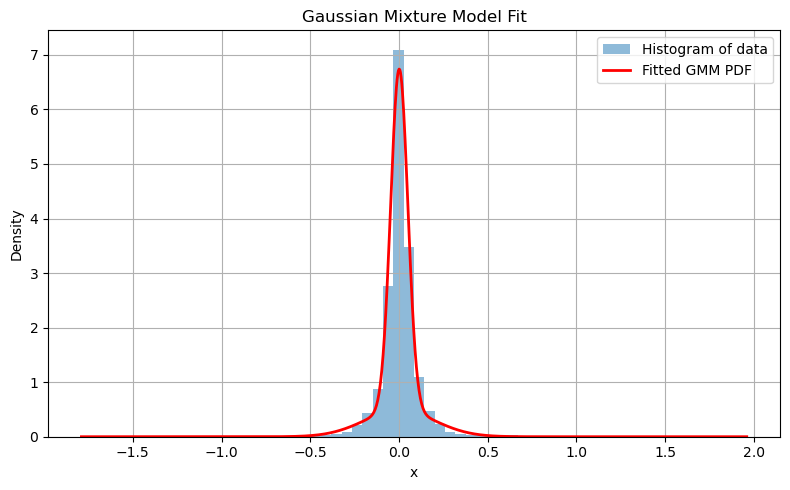

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# === Generate example data (or replace with your own) ===
data = np.array(get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"])
data = data.reshape(-1, 1)

# === Fit a GMM ===
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(data)

# === Create a grid of x values to evaluate the PDF ===
x = np.linspace(data.min() - 1, data.max() + 1, 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

# === Plot ===
plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of data')
plt.plot(x, pdf, 'r-', linewidth=2, label='Fitted GMM PDF')
plt.title('Gaussian Mixture Model Fit')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import laplace, kstest
import numpy as np

def anderson_darling_laplace(data):
    data = np.sort(np.array(data))
    n = len(data)

    # Step 1: Fit Laplace distribution to data
    loc, scale = laplace.fit(data)

    # Step 2: Compute the Laplace CDF values at sorted data points
    cdf_vals = laplace.cdf(data, loc=loc, scale=scale)

    # Step 3: Compute the A-D statistic
    i = np.arange(1, n + 1)
    term1 = (2 * i - 1) * np.log(cdf_vals)
    term2 = (2 * (n - i) + 1) * np.log(1 - cdf_vals[::-1])
    A2 = -n - np.sum(term1 + term2) / n

    return A2, loc, scale

A2, loc, scale = anderson_darling_laplace(get_df_d2d(df, 0)[f"day_to_day_{fev1_col}"])
print(f"Anderson–Darling statistic: {A2:.4f}")

## Plots using all the data

In [51]:
def get_day_to_day_ecFEV1(df_for_ID, n_days, fev1_col="ecFEV1"):
    df_for_ID = df_for_ID.sort_values(by="Date Recorded", ascending=True)
    df_for_ID[f"day_to_day_{fev1_col}"] = df_for_ID[fev1_col].diff(periods=n_days)
    return df_for_ID

In [52]:
fev1_col = "ecFEV1"
# fev1_col = "FEV1"
n_days = 1
df_d2d = df.groupby("ID").apply(get_day_to_day_ecFEV1, n_days, fev1_col)
d2d = df_d2d[f"day_to_day_{fev1_col}"].dropna().reset_index().drop(columns=["level_1"])

# Plot histogram of
fig = make_subplots(rows=3, cols=1)
xbins = dict(start=-0.605, end=0.605, size=0.01)
fig.add_trace(
    go.Histogram(x=d2d[f"day_to_day_{fev1_col}"], xbins=xbins, histnorm="probability")
)
# Transform xbins into an array
xbins = np.linspace(
    xbins["start"], xbins["end"], round((xbins["end"] - xbins["start"]) / xbins["size"])
)
# Using matplotlib get hist probability
hist, val = np.histogram(d2d[f"day_to_day_{fev1_col}"], bins=xbins, density=True)
print(f"len hist: {len(hist)}, len val: {len(val)}")
# Get idx where val is 0
[idx_0] = np.where(val == 0)[0]
neg_shift = hist[:idx_0]
neg_val = val[:idx_0]
pos_shift = hist[idx_0:]
pos_val = val[idx_0+1:]
print(f"len neg_shift: {len(neg_shift)} with last val {neg_val[-1]} , len pos_shift: {len(pos_shift)} with first val {pos_val[0]}")
abs_shift = neg_shift + pos_shift[::-1]
print(f"sum of abs_shift: {sum(abs_shift)}")

# Comute cumsum
fig.add_trace(go.Bar(x=pos_val[::-1], y=abs_shift), row=2, col=1)

cumsum = np.cumsum(abs_shift[::-1])
fig.add_trace(go.Bar(x=pos_val, y=cumsum), row=3, col=1)

fig.update_xaxes(title_text=f"Day-to-day change in {fev1_col}", row=1, col=1, nticks=10)
fig.update_xaxes(
    title_text=f"Absolute day-to-day change in {fev1_col}", row=2, col=1, nticks=10#, title_standoff=10
)
fig.update_xaxes(
    title_text=f"Cumulative absolute day-to-day change in {fev1_col}", row=3, col=1, nticks=10#, title_standoff=10
)
fig.update_yaxes(title_text="Occurence (%)", row=2, col=1)
fig.update_yaxes(title_text="Occurence (%)", row=3, col=1)
fig.update_layout(
    title=f"Change in {fev1_col} over {n_days} days",
    width=600,
    height=650,
    font_size=10,
    showlegend=False
)
fig.show()

len hist: 120, len val: 121
len neg_shift: 60 with last val -0.010083333333333333 , len pos_shift: 60 with first val 0.010083333333333333
sum of abs_shift: 99.17355371900828


In [6]:
# Plot this per individual
for id in d2d["ID"].unique():
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(
            x=d2d[d2d["ID"] == id]["day_to_day_ecFEV1"],
            xbins=xbins,
            histnorm="probability",
        )
    )
    fig.update_xaxes(title_text="Day-to-day change in ecFEV1", range=[-0.5, 0.5])
    title = f"ID {id} - Change in ecFEV1 over {n_days} days"
    fig.update_layout(title=title, width=800, height=400)
    fig.write_image(
        f"{dh.get_path_to_main()}/PlotsBreathe/Interconnecting_ARs_entries/day_to_day_ecFEV1/{title}.pdf"
    )


KeyboardInterrupt



In [15]:
# Quantify amount of same day to day values

fev1_col = "FEV1"
n_days = 1
df_d2d = df.groupby("ID").apply(get_day_to_day_ecFEV1, n_days, fev1_col)
d2d = df_d2d[f"day_to_day_{fev1_col}"].dropna().reset_index().drop(columns=["level_1"])
n_0_diff = (
    d2d[f"day_to_day_{fev1_col}"].where(d2d[f"day_to_day_{fev1_col}"] == 0).count()
)
print(f"Amount of 0 diff for FEV1 {n_0_diff}/{len(d2d)}")

fev1_col = "ecFEV1"
n_days = 1
df_d2d = df.groupby("ID").apply(get_day_to_day_ecFEV1, n_days, fev1_col)
d2d = df_d2d[f"day_to_day_{fev1_col}"].dropna().reset_index().drop(columns=["level_1"])
n_0_diff = (
    d2d[f"day_to_day_{fev1_col}"].where(d2d[f"day_to_day_{fev1_col}"] == 0).count()
)
print(f"Amount of 0 diff for ecFEV1 {n_0_diff}")

Amount of 0 diff for FEV1 2318/40908
Amount of 0 diff for ecFEV1 3030


In [54]:
df_valc = pd.DataFrame(d2d.value_counts()).reset_index().set_index("ID")
df_valc = df_valc[df_valc.index == "101"]

# Bar plot of the number of days for each ID
fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Bar(y=df_valc.index, x=df_valc["count"], orientation="h", name="all data"),
    row=1,
    col=1,
)
for val in df_valc["day_to_day_ecFEV1"].unique():
    fig.add_trace(
        go.Bar(
            y=df_valc.index,
            x=df_valc[df_valc["day_to_day_ecFEV1"] == val]["count"],
            orientation="h",
            name=f"diff={val}",
        ),
        row=1,
        col=1,
    )
# fig.add_trace(
#     go.Bar(y=df_valc.index, x=df_valc[df_valc["day_to_day_ecFEV1"] == 0]["count"], orientation="h", name="all data", marker_color=dh.get_blind_colours()[1]), row=1, col=1
# )
# fig.add_trace(
#     go.Bar(y=df_valc.index, x=df_valc[df_valc["day_to_day_ecFEV1"] == 0.01]["count"], orientation="h", name="all data", marker_color=dh.get_blind_colours()[2]), row=1, col=1
# )
fig.update_layout(
    title_text="Number of consecutive days for each ID", height=400, font_size=8
)

fig.show()

In [62]:
import plotly.graph_objects as go

# Assuming df_valc is a DataFrame with columns: "count", "day_to_day_ecFEV1", and an index
# Create a list of unique values for day_to_day_ecFEV1
unique_values = df_valc["day_to_day_ecFEV1"].unique()

# Create a color map for each unique value
# color_map = {
#     value: color for value, color in zip(unique_values, ["red", "blue", "green", "orange", "purple"])
# }

# Create a figure
fig = go.Figure()

# Add a bar trace for each unique value of day_to_day_ecFEV1
for value in unique_values:
    filtered_data = df_valc[df_valc["day_to_day_ecFEV1"] == value]
    fig.add_trace(
        go.Bar(
            y=filtered_data.index,
            x=filtered_data["count"],
            orientation="h",
            name=f"day_to_day_ecFEV1: {value}",
            # marker=dict(color=color_map[value])
        )
    )

# Update layout to show the legend
fig.update_layout(
    barmode="stack",  # Stack the bars
    title="Bar Plot with Segments and Legend",
    xaxis_title="Count",
    yaxis_title="Index",
    legend_title="day_to_day_ecFEV1",
    height=300,
    width=1000,
)

# Show the figure
fig.show()

## Day to day diff in L of FEV1

Knowing that 0.1 diff is approx 2%

In [16]:
df

,ID,Date Recorded,FEV1,O2 Saturation,FEF2575,ecFEV1,ecFEF2575,Sex,Height,Age,Predicted FEV1,Healthy O2 Saturation,ecFEV1 % Predicted,FEV1 % Predicted,O2 Saturation % Healthy,ecFEF2575%ecFEV1,idx ecFEV1 (L),idx O2 saturation (%),idx ecFEF2575%ecFEV1,idx ecFEF25-75 % ecFEV1 (%)
0,101,2019-01-25,1.31,97,0.54,1.31,0.54,Male,173.0,53,3.610061,97.150104,36.287474,36.287474,99.845492,41.221374,26,47,20,20
1,101,2019-01-26,1.31,98,0.57,1.31,0.57,Male,173.0,53,3.610061,97.150104,36.287474,36.287474,100.874827,43.511450,26,48,21,21
2,101,2019-01-27,1.31,96,0.67,1.31,0.67,Male,173.0,53,3.610061,97.150104,36.287474,36.287474,98.816157,51.145038,26,46,25,25
3,101,2019-01-28,1.30,96,0.69,1.30,0.69,Male,173.0,53,3.610061,97.150104,36.010470,36.010470,98.816157,53.076923,26,46,26,26
4,101,2019-01-29,1.28,98,0.60,1.28,0.60,Male,173.0,53,3.610061,97.150104,35.456463,35.456463,100.874827,46.875000,25,48,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41255,553,2023-10-08,4.12,98,4.20,4.12,4.20,Male,179.0,18,4.619116,97.042483,89.194549,89.194549,100.986699,101.941748,82,48,50,50
41256,553,2023-10-11,4.15,97,4.06,4.15,4.06,Male,179.0,18,4.619116,97.042483,89.844024,89.844024,99.956223,97.831325,83,47,48,48
41257,553,2023-11-06,4.13,97,4.84,4.13,4.84,Male,179.0,18,4.619116,97.042483,89.411041,89.411041,99.956223,117.191283,82,47,58,58
41258,553,2023-11-08,4.05,96,4.71,4.05,4.71,Male,179.0,18,4.619116,97.042483,87.679108,87.679108,98.925746,116.296296,81,46,58,58
